In [1]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout, to_agraph
from networkx.algorithms.simple_paths import all_simple_paths
import pygraphviz as pgv
from IPython.display import Image
from matplotlib import pyplot as plt
from matplotlib import colors
from random import shuffle
from itertools import cycle, chain
from collections import defaultdict
import json
import yaml

%matplotlib inline

In [2]:
def plt_draw(graph, colors=None, figsize=(30,30)):
    if colors is None:
        colors = ["white" for n in graph.nodes]
    plt.figure(figsize=figsize)
    pos = graphviz_layout(graph, prog="dot")
    nx.draw(graph, with_labels=True, node_color=colors)

In [3]:
css_colors = list(colors.CSS4_COLORS.keys())
shuffle(css_colors)
colors = list(colors.BASE_COLORS.keys()) + css_colors
colors = cycle(colors)

In [4]:
def do_wave(n, color):
    print("Starting wave", n)
    waves[n] = list()
    for package in waves[n-1]:
        print(f"# {package}")
        what_requires = !repoquery --repo=koji --qf '%{{NAME}}' --whatrequires {package} 2> /dev/null
        for dependant in what_requires:
            if dependant in binary_exc:
                print("X", dependant, "has an exception")
                continue
            if dependant not in g.nodes:
                print("A", dependant, "→", package)
                waves[n].append(dependant)
                g.add_edge(dependant, package)
                node_colors.append(color)
    print(len(waves[n]), "new packages")
    return len(waves[n])

## Maintainers

In [5]:
with open("../portingdb/data/pagure_owner_alias.json") as fh:
    maintainers = json.load(fh)["rpms"]

inverse_maintainers = defaultdict(list)
for srpm in maintainers:
    for maintainer in maintainers[srpm]:
        inverse_maintainers[maintainer].append(srpm)

## Orphaned packages

In [6]:
srpm_orphans = []
for srpm, srpm_maintainers in maintainers.items():
    if "orphan" in srpm_maintainers:
        srpm_orphans.append(srpm)

## Exceptions

Get groups from portingdb

In [7]:
with open("../portingdb/data/groups.yaml") as fh:
    groups = yaml.load(fh, Loader=yaml.SafeLoader)

Get all non-hidden source RPM packages (have an exception)

In [8]:
source_exc = []
for srpm, info in groups.items():
    if info.get("hidden", False):
        continue
    for package in info["packages"]:
        source_exc.append(package)

In [9]:
source_exc.extend(["mercurial", "autodownloader"])  # manually added exceptions

Get mapping from portingdb to get binary RPMs from source RPMs

In [10]:
with open("../portingdb/_check_drops/results-sources.json") as fh:
    srpm_mapping = json.load(fh)

In [11]:
binary_exc = []
for package in source_exc:
    binary_exc.extend(srpm_mapping[package])

In [12]:
binary_exc.append("python2-capstone")  # Bogus dependencies https://bugzilla.redhat.com/show_bug.cgi?id=1760277#c1
binary_exc.append("python3-dmidecode")  # Vztah "python3-dmidecode → python2-libxml2" je třeba odebrat, protože jde o stejný problém jako u capstone (python3-dmidecode requiruje libxml2mod.so()(64bit), to je providované oběma pythonX-libxml2).

In [13]:
print(f"SRPM exceptions - {source_exc}\nRPM exceptions {binary_exc}")

SRPM exceptions - ['gimp', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2', 'pygtk2', 'pycairo', 'chromium', 'python-psutil', 'mlt', 'postgresql', 'pypy', 'pypy3', 'qt5-qtwebengine', 'texlive-base', 'mercurial', 'autodownloader']
RPM exceptions ['gimp-devel', 'gimp', 'gimp-libs', 'gimp-devel-tools', 'gimp-layer-via-copy-cut', 'gimp-resynthesizer', 'pygobject2-devel', 'pygobject2', 'pygobject2-doc', 'pygobject2-codegen', 'pygtk2-codegen', 'pygtk2-devel', 'pygtk2-doc', 'pygtk2-libglade', 'pygtk2', 'python3-cairo-devel', 'python3-cairo', 'python2-cairo-devel', 'python2-cairo', 'chromium-common', 'chromium-headless', 'chromium-libs-media', 'chromedriver', 'chromium-libs', 'chromium', 'chrome-remote-desktop', 'python2-psutil', 'python3-psutil', 'python2-mlt', 'mlt', 'mlt-ruby', 'mlt-php', 'mlt-devel', 'postgresql', 'postgresql-plpython3', 'postgresql-plperl', 'postgresql-pltcl', 'postgresql-test-rpm-macros', 'postgresql-test', 'postgresql-contrib', 'postgresql-server-devel', '

## Wave #1 - packages directly depending on python27

In [14]:
waves = {}

In [15]:
python27 = !repoquery --repo=koji --qf "%{NAME}" --whatrequires python27 2> /dev/null

In [16]:
waves[1] = set([p for p in python27 if p not in binary_exc])

In [17]:
g = nx.DiGraph()
node_colors = []

In [18]:
g.add_nodes_from(waves[1])

In [19]:
for package in waves[1]:
    g.add_edge(package, "PY2")
    # g.add_node(package)
    node_colors.append("red")
node_colors.append("red")

In [20]:
len(waves[1])

416

## Wave 2, 3, 4, …

In [21]:
for n in range(2, 20):
    color = next(colors)
    new_pkgs = do_wave(n, color)
    if new_pkgs == 0:
        break

Starting wave 2
# freeorion
# python2-backports
# python2-qpid
# python2-scales
# trac-tracnav-plugin
# python2-pygments
A docco → python2-pygments
A gcc-python2-debug-plugin → python2-pygments
# python2-kiwisolver
# trac-git-plugin
# python2-pluggy
# python2-visvis
# python2-qpid-messaging
# python2-nose
# slingshot
# python2-ioprocess
# python2-gflags
# shiboken-python2-libs
A shiboken → shiboken-python2-libs
# python2-newt
# python2-mistune
# trac-tocmacro-plugin
# python2-augeas
# python2-pyOpenSSL
# python2-pathlib2
# python2-pypandoc
# python2-jenkinsapi
# trac-blackmagictickettweaks-plugin
# python2-pytest
# python2-musicbrainzngs
# sugar-xoirc
# trac-accountmanager-plugin
# sugar-starchart
# python2-pyside
A python-pyside-devel → python2-pyside
# samtools
A mmseq → samtools
# python2-volatility
# python2-libxml2
X python3-dmidecode has an exception
# python2-colorclass
# python2-pillow-devel
# tryton
# python2-pytest-runner
# python2-jinja2
# sx
# python2-tbgrep
# mailman
# pyt

# python2-gammu
# NFStest
# batti
# python2-qt5-webkit
# trac-workflowadmin-plugin
# python2-pbr
# sugar-connect
# rdiff-backup
A backupninja → rdiff-backup
A safekeep-common → rdiff-backup
# sugar-clock
# python2-PyPDF2
# python2-staplelib
# python2-abiword
# pdf-stapler
# python2-qt5
# tortoisehg
A tortoisehg-nautilus → tortoisehg
# sugar-nutrition
# glue-validator
# sugar-fractionbounce
# sugar-pippy
# python2-easygui
# python2-ldap
# dynafed
A dynafed-dmlite-frontend → dynafed
A dynafed-dmlite-plugin → dynafed
A dynafed-http-plugin → dynafed
A dynafed-lfc-plugin → dynafed
A dynafed-private-devel → dynafed
A dynafed-tpc-gfal2 → dynafed
# sugar-hello-world
# python2-Cython
# python2-markupsafe
# python2-matplotlib
A python2-matplotlib-doc → python2-matplotlib
A python2-matplotlib-test-data → python2-matplotlib
# sugar-speak
# func
# gourmet
# system-config-httpd
# comix
# python2-sqlobject
# trac-authopenid-plugin
# python2-saslwrapper
# python2-setuptools
# python2-pillow
# mcomix
#

# asterisk-snmp
# asterisk-sounds-core-en
# asterisk-sounds-core-en-alaw
# asterisk-sounds-core-en-g722
# asterisk-sounds-core-en-g729
# asterisk-sounds-core-en-gsm
# asterisk-sounds-core-en-siren14
# asterisk-sounds-core-en-siren7
# asterisk-sounds-core-en-sln16
# asterisk-sounds-core-en-ulaw
# asterisk-sounds-core-en-wav
# asterisk-sounds-core-en_AU
# asterisk-sounds-core-en_AU-alaw
# asterisk-sounds-core-en_AU-g722
# asterisk-sounds-core-en_AU-g729
# asterisk-sounds-core-en_AU-gsm
# asterisk-sounds-core-en_AU-siren14
# asterisk-sounds-core-en_AU-siren7
# asterisk-sounds-core-en_AU-sln16
# asterisk-sounds-core-en_AU-ulaw
# asterisk-sounds-core-en_AU-wav
# asterisk-sounds-core-en_GB
# asterisk-sounds-core-en_GB-alaw
# asterisk-sounds-core-en_GB-g722
# asterisk-sounds-core-en_GB-g729
# asterisk-sounds-core-en_GB-gsm
# asterisk-sounds-core-en_GB-siren14
# asterisk-sounds-core-en_GB-siren7
# asterisk-sounds-core-en_GB-sln16
# asterisk-sounds-core-en_GB-ulaw
# asterisk-sounds-core-en_GB-w

## Save

In [22]:
nx.write_adjlist(g, "full_graph.adjlist")

In [23]:
waves[1] = list(waves[1])

In [24]:
with open("wawes.json", "w") as fh:
    json.dump(waves, fh)
with open("node_colors.json", "w") as fh:
    json.dump(node_colors, fh)

## Load

In [25]:
with open("wawes.json") as fh:
    waves = json.load(fh)
with open("node_colors.json") as fh:
    node_colors = json.load(fh)

In [26]:
g = nx.read_adjlist("full_graph.adjlist", create_using=nx.DiGraph())

In [27]:
"PY2" in g.nodes

True

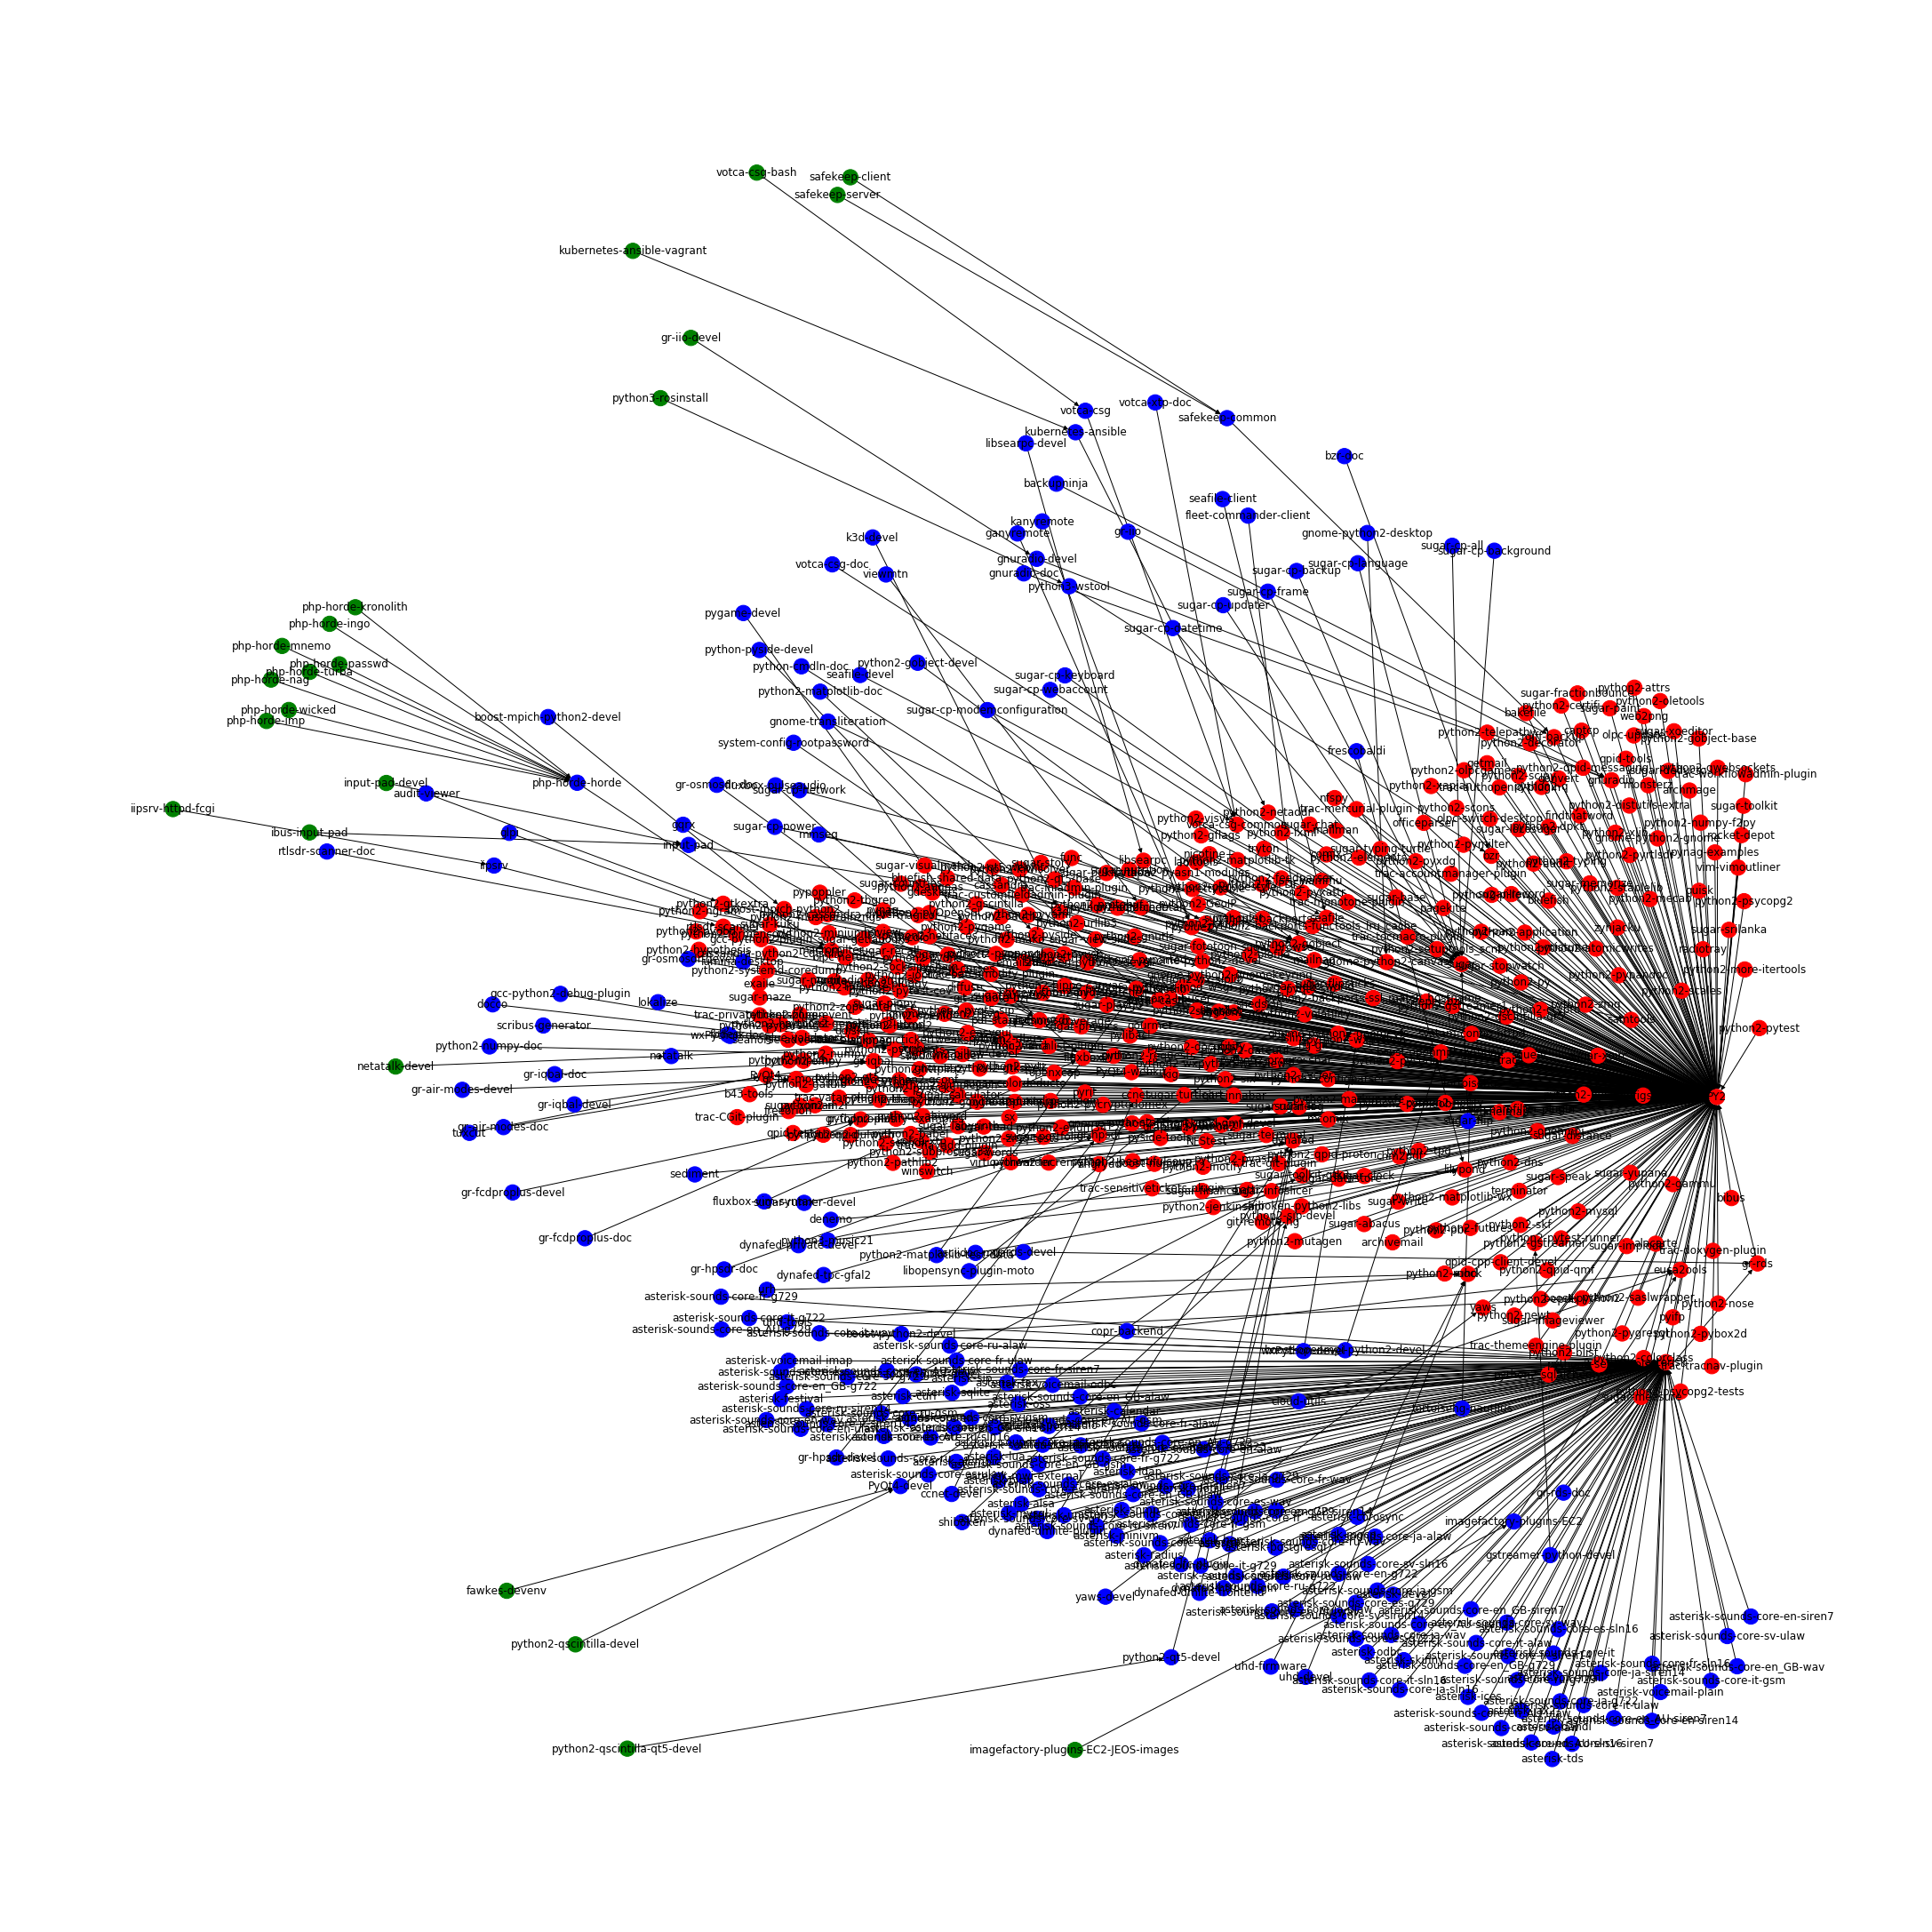

In [28]:
plt_draw(g, node_colors)

## List of packages and theirs paths to Python 2 (including the packages in the first wave)

In [29]:
len(waves)

4

In [30]:
with open("packages.txt", "w") as packages_file:
    binary_packages = list(chain(*[waves[str(n)] for n in waves.keys()]))
    print("Total packages", len(binary_packages))
    for package in sorted(binary_packages):
        path = list(all_simple_paths(g, package, 'PY2'))[0]
        line = f"{package} ({' → '.join(path)})"
        print(line)
        print(line, file=packages_file)

!scp packages.txt fedorapeople.org:public_html/ >/dev/null

Total packages 670
NFStest (NFStest → PY2)
PyQt4 (PyQt4 → PY2)
PyQt4-devel (PyQt4-devel → python2-sip-devel → PY2)
PyQt4-webkit (PyQt4-webkit → PY2)
alacarte (alacarte → PY2)
angrydd (angrydd → PY2)
archivemail (archivemail → PY2)
archmage (archmage → PY2)
asciidoc-music (asciidoc-music → lilypond → PY2)
asterisk (asterisk → PY2)
asterisk-ael (asterisk-ael → asterisk → PY2)
asterisk-alembic (asterisk-alembic → asterisk → PY2)
asterisk-alsa (asterisk-alsa → asterisk → PY2)
asterisk-calendar (asterisk-calendar → asterisk → PY2)
asterisk-corosync (asterisk-corosync → asterisk → PY2)
asterisk-curl (asterisk-curl → asterisk → PY2)
asterisk-dahdi (asterisk-dahdi → asterisk → PY2)
asterisk-devel (asterisk-devel → asterisk → PY2)
asterisk-fax (asterisk-fax → asterisk → PY2)
asterisk-festival (asterisk-festival → asterisk → PY2)
asterisk-hep (asterisk-hep → asterisk → PY2)
asterisk-iax2 (asterisk-iax2 → asterisk → PY2)
asterisk-ices (asterisk-ices → asterisk → PY2)
asterisk-ldap (asterisk-ldap 

## List of all SRPMs and theirs RPMs

In [31]:
inverse_srpm_map = {}
for srpm, pkgs in srpm_mapping.items():
    inverse_srpm_map.update({pkg: srpm for pkg in pkgs})

In [32]:
srpms = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    srpms[srpm].append(package)

## List of affected maintainers and their binary RPMs

In [33]:
affected_maintainers = defaultdict(list)
for package in binary_packages:
    try:
        srpm = inverse_srpm_map[package]
    except KeyError:
        srpm = "N/A"
    for maintainer in maintainers.get(srpm, []):
        affected_maintainers[maintainer].append(package)

with open("affected_maintainers.txt", "w") as affected_maintainer_file:
    for maintainer, pkgs in sorted(affected_maintainers.items(), key=lambda x: x[0]):
        line = f"{maintainer} - {', '.join(pkgs)}"
        print(line)
        print(line, file=affected_maintainer_file)

!scp affected_maintainers.txt fedorapeople.org:public_html/ >/dev/null

aarem - python2-more-itertools, python2-PyPDF2, python2-staplelib, pdf-stapler
abbot - python2-protobuf
abompard - python2-pysocks, python2-mako, python2-urllib3, python2-requests, python2-coverage, python2-zope-event, python2-httplib2
acaringi - cassandra-python2-cqlshlib, cassandra
ajmitchell - NFStest
alexl - alacarte, gnome-python2-gnomevfs, python2-ldap, gnome-python2-libwnck, gnome-python2-gnome, python2-dbus, gnome-python2-canvas, gnome-python2-gnomekeyring, gnome-python2-devel, gnome-python2-rsvg, gnome-python2-gconf, gnome-python2-gtkspell, gnome-python2-desktop
alexlan - graphviz-python2
alikins - func
amluto - python2-musicbrainzngs
andreamanzi - dynafed, dynafed-dmlite-frontend, dynafed-dmlite-plugin, dynafed-http-plugin, dynafed-lfc-plugin, dynafed-private-devel, dynafed-tpc-gfal2
anishpatil - gnome-transliteration
ankursinha - python3-wstool
anyremote - ganyremote, kanyremote
aperezbios - sugar, sugar-cp-all, sugar-cp-background, sugar-cp-backup, sugar-cp-datetime, sugar-

## Combined structure

In [34]:
structure = defaultdict(lambda: defaultdict(list))
for binary_pkg in binary_packages:
    try:
        srpm = inverse_srpm_map[binary_pkg]
        srpm_maintainers = maintainers[srpm]
    except KeyError:
        srpm = "N/A"
        srpm_maintainers = ["N/A"]
    for maintainer in srpm_maintainers:
        structure[maintainer][srpm].append(binary_pkg)

# Build dependencies (direct)

In [35]:
srpm_dependants = []
for package in sorted(binary_packages):
    build_requires = !repoquery --repo=koji-source --repo=koji --qf "%{{NAME}} %{{ARCH}}" --whatrequires {package} 2>/dev/null | grep " src$" | cut -d " " -f 1
    print(f"{package} in required in build time by {build_requires}")
    for srpm in build_requires:
        if srpm in srpms.keys() or srpm in srpm_dependants:
            print(f"✅ {srpm} is already in the graph")
            continue
        if srpm in source_exc:
            print(f"✅ {srpm} in in the list of source ackages with exceptions")
            continue
        try:
            rpms = srpm_mapping[srpm]
        except KeyError:
            print(f"Cannot get RPMs for {srpm}")
            continue
        if any([p.startswith("python2-") for p in rpms]):
            print(f"✅ {srpm} provides python2 subpackage - {rpms}")
            continue
        
        srpm_dependants.append(srpm)
        g.add_edge(srpm, package)
        srpm_maintainers = maintainers[srpm]
        for maintainer in srpm_maintainers:
            structure[maintainer][srpm].insert(0, "SRPM")  # For these special cases, we'll generate path for SRPM

NFStest in required in build time by []
PyQt4 in required in build time by []
PyQt4-devel in required in build time by ['gnuradio', 'gr-air-modes', 'hgview', 'python-poppler-qt4', 'qscintilla']
✅ gnuradio is already in the graph
✅ gr-air-modes is already in the graph
✅ hgview is already in the graph
✅ qscintilla is already in the graph
PyQt4-webkit in required in build time by []
alacarte in required in build time by []
angrydd in required in build time by []
archivemail in required in build time by []
archmage in required in build time by []
asciidoc-music in required in build time by []
asterisk in required in build time by []
asterisk-ael in required in build time by []
asterisk-alembic in required in build time by []
asterisk-alsa in required in build time by []
asterisk-calendar in required in build time by []
asterisk-corosync in required in build time by []
asterisk-curl in required in build time by []
asterisk-dahdi in required in build time by []
asterisk-devel in required in 

batti in required in build time by []
bibus in required in build time by []
bluefish in required in build time by []
bluefish-shared-data in required in build time by []
boost-mpich-python2 in required in build time by []
boost-mpich-python2-devel in required in build time by []
boost-numpy2 in required in build time by []
boost-openmpi-python2 in required in build time by []
boost-openmpi-python2-devel in required in build time by []
boost-python2 in required in build time by []
boost-python2-devel in required in build time by ['freeorion', 'k3d', 'ledger', 'python-gattlib']
✅ freeorion is already in the graph
✅ k3d is already in the graph
✅ python-gattlib is already in the graph
bzr in required in build time by ['etckeeper', 'golang-github-masterminds-vcs', 'ikiwiki', 'python-pip', 'python-vcstools', 'python-wstool']
✅ etckeeper is already in the graph
✅ python-wstool is already in the graph
bzr-doc in required in build time by []
captcp in required in build time by []
cassandra in r

php-horde-horde in required in build time by ['php-horde-wicked']
✅ php-horde-wicked is already in the graph
php-horde-imp in required in build time by []
php-horde-ingo in required in build time by []
php-horde-kronolith in required in build time by []
php-horde-mnemo in required in build time by []
php-horde-nag in required in build time by []
php-horde-passwd in required in build time by []
php-horde-turba in required in build time by []
php-horde-wicked in required in build time by []
pybluez in required in build time by ['wammu']
✅ wammu is already in the graph
pycdio in required in build time by []
pygame-devel in required in build time by []
pyifp in required in build time by []
pylibacl in required in build time by []
pynag in required in build time by []
pynag-examples in required in build time by []
pypoppler in required in build time by []
pyrit in required in build time by []
pyside-tools in required in build time by []
python-cmdln-doc in required in build time by []
pytho

python2-ldap in required in build time by []
python2-libuser in required in build time by []
python2-libxml2 in required in build time by ['bakefile', 'bamf']
✅ bakefile is already in the graph
python2-lxml in required in build time by ['gcc-python-plugin', 'gnuradio', 'python-openid']
✅ gcc-python-plugin is already in the graph
✅ gnuradio is already in the graph
✅ python-openid is already in the graph
python2-m2r in required in build time by ['python-pyrtlsdr']
✅ python-pyrtlsdr is already in the graph
python2-mako in required in build time by ['gnuradio', 'uhd']
✅ gnuradio is already in the graph
✅ uhd is already in the graph
python2-markupsafe in required in build time by ['python-jinja2', 'python-mako']
✅ python-jinja2 is already in the graph
✅ python-mako is already in the graph
python2-matplotlib in required in build time by []
python2-matplotlib-doc in required in build time by []
python2-matplotlib-test-data in required in build time by []
python2-matplotlib-tk in required in b

python2-pytest-cov in required in build time by ['python-dpkt']
✅ python-dpkt is already in the graph
python2-pytest-runner in required in build time by ['python-backports-functools_lru_cache']
✅ python-backports-functools_lru_cache is already in the graph
python2-pytz in required in build time by ['python-astral', 'python-google-apputils', 'python-jenkinsapi', 'python-tasklib', 'python2-matplotlib']
✅ python-google-apputils is already in the graph
✅ python-jenkinsapi is already in the graph
✅ python2-matplotlib is already in the graph
python2-pyusb in required in build time by ['python-yubico']
python2-pyxattr in required in build time by []
python2-pyxdg in required in build time by ['radiotray']
✅ radiotray is already in the graph
python2-pyyaml in required in build time by ['tarantool']
python2-q in required in build time by []
python2-qpid in required in build time by []
python2-qpid-messaging in required in build time by []
python2-qpid-proton in required in build time by []
pyth

python2-setuptools_scm in required in build time by ['python-backports-functools_lru_cache', 'python-dateutil', 'python-py', 'python-pytest-runner', 'python-xlib', 'python2-pluggy', 'python2-pytest']
✅ python-backports-functools_lru_cache is already in the graph
✅ python-dateutil is already in the graph
✅ python-py is already in the graph
✅ python-pytest-runner is already in the graph
✅ python-xlib is already in the graph
✅ python2-pluggy is already in the graph
✅ python2-pytest is already in the graph
python2-simplejson in required in build time by ['libsearpc', 'python-oauth2', 'python-scales']
✅ libsearpc is already in the graph
✅ python-oauth2 is already in the graph
✅ python-scales is already in the graph
python2-sip-devel in required in build time by ['PyQt4', 'avogadro', 'python-qt5', 'qgis', 'qscintilla', 'veusz', 'vtk']
✅ PyQt4 is already in the graph
✅ python-qt5 is already in the graph
✅ qscintilla is already in the graph
python2-six in required in build time by ['gcc-python

sugar-read in required in build time by []
sugar-recall in required in build time by []
sugar-record in required in build time by []
sugar-ruler in required in build time by []
sugar-runner in required in build time by []
sugar-runner-devel in required in build time by []
sugar-speak in required in build time by []
sugar-srilanka in required in build time by []
sugar-starchart in required in build time by []
sugar-stopwatch in required in build time by []
sugar-story in required in build time by []
sugar-terminal in required in build time by []
sugar-toolkit in required in build time by ['sugar-castle', 'sugar-connect', 'sugar-countries', 'sugar-deducto', 'sugar-flipsticks', 'sugar-kuku', 'sugar-labyrinth', 'sugar-playgo', 'sugar-srilanka', 'sugar-starchart', 'sugar-view-slides', 'sugar-xomail']
✅ sugar-castle is already in the graph
✅ sugar-connect is already in the graph
✅ sugar-countries is already in the graph
✅ sugar-deducto is already in the graph
✅ sugar-flipsticks is already in

### Save

In [36]:
with open("structure.json", "w") as fh:
    json.dump(structure, fh)

### Load

In [37]:
with open("structure.json") as fh:
    structure = json.load(fh)

# Final outputs

## Package structure with paths

In [38]:
with open("report.txt", "w") as report_file:
    for maintainer in sorted(structure.keys()):
        # Skip orphans and unknown maintainers
        if maintainer in ("N/A", "orphan"):
            continue
        lines = []
        lines.append(maintainer)
        for srpm in sorted(structure[maintainer]):
            # Skip orphaned packages
            if srpm in srpm_orphans:
                continue
            lines.append(f"  {srpm}")
            rpms = sorted(structure[maintainer][srpm])
            if srpm in rpms:
                rpms.remove(srpm)
                rpms.insert(0, srpm)
            for rpm in rpms:
                marker = "→ "
                if rpm == "SRPM":
                    rpm = srpm
                    marker = "BuildRequires: "

                # Mark all orphaned packages in the path by (!)
                path = list(all_simple_paths(g, rpm, 'PY2'))[0]
                for index, package in enumerate(path):
                    try:
                        if inverse_srpm_map[package] in srpm_orphans:
                            path[index] = f"{package} (!)"
                    except KeyError:
                        pass

                if path[0] == srpm:
                    del path[0]
                    str_path = marker + ' → '.join(path)
                    line = f"    ({str_path})"
                else:
                    del path[0]
                    str_path = '→ ' + ' → '.join(path)
                    line = f"    {rpm} ({str_path})"
                lines.append(line)

        if any([True for l in lines if l.startswith(" "*4)]):
            print("\n".join(lines))
            print("\n".join(lines), file=report_file)

!scp report.txt fedorapeople.org:public_html/ >/dev/null

aarem
  pdf-stapler
    (→ PY2)
    python2-staplelib (→ PY2)
  python-PyPDF2
    python2-PyPDF2 (→ PY2)
  python2-more-itertools
    (→ PY2)
abbot
  protobuf
    python2-protobuf (→ PY2)
abompard
  python-coverage
    python2-coverage (→ PY2)
  python-httplib2
    python2-httplib2 (→ PY2)
  python-mako
    python2-mako (→ PY2)
  python-pysocks
    python2-pysocks (→ PY2)
  python-requests
    python2-requests (→ PY2)
  python-urllib3
    python2-urllib3 (→ PY2)
  python-zope-event
    python2-zope-event (→ PY2)
ajmitchell
  NFStest
    (→ PY2)
alexl
  dbus
    (BuildRequires: python2-gobject → PY2)
  dbus-python
    python2-dbus (→ PY2)
  gnome-python2
    gnome-python2-canvas (→ PY2)
    gnome-python2-devel (→ PY2)
    gnome-python2-gconf (→ PY2)
    gnome-python2-gnome (→ PY2)
    gnome-python2-gnomevfs (→ PY2)
  gnome-python2-desktop
    (→ gnome-python2-canvas → PY2)
    gnome-python2-gnomekeyring (→ PY2)
    gnome-python2-libwnck (→ PY2)
    gnome-python2-rsvg (→ PY2)
  python-ld

fcami
  scribus
    (→ PY2)
filabrazilska
  python-scales
    python2-scales (→ PY2)
filiperosset
  bakefile
    (→ PY2)
  python-empy
    python2-empy (→ PY2)
firewing
  python-crypto
    python2-crypto (→ PY2)
frankcrawford
  rdiff-backup
    (→ PY2)
  safekeep
    safekeep-client (→ safekeep-common → rdiff-backup → PY2)
    safekeep-common (→ rdiff-backup → PY2)
    safekeep-server (→ safekeep-common → rdiff-backup → PY2)
frostyx
  copr-backend
    (→ euca2ools (!) → PY2)
fschwarz
  babel
    python2-babel (→ PY2)
  python-genshi
    python2-genshi (→ PY2)
  python-pyside
    python-pyside-devel (→ python2-pyside → PY2)
    python2-pyside (→ PY2)
  shiboken
    (→ shiboken-python2-libs → PY2)
    shiboken-python2-devel (→ PY2)
    shiboken-python2-libs (→ PY2)
  trac
    (→ PY2)
fujiwara
  ibus-input-pad
    (→ input-pad → python2-gobject → PY2)
  input-pad
    (→ python2-gobject → PY2)
    input-pad-devel (→ input-pad → python2-gobject → PY2)
gbcox
  oggify
    (→ PY2)
geertj
  pys

kevin
  pylibacl
    (→ PY2)
  pyp2rpm
    (BuildRequires: python2-setuptools → PY2)
  python-decorator
    python2-decorator (→ PY2)
  python-httplib2
    python2-httplib2 (→ PY2)
  python-pysocks
    python2-pysocks (→ PY2)
  pyxattr
    python2-pyxattr (→ PY2)
  rdiff-backup
    (→ PY2)
  trac-authopenid-plugin
    (→ PY2)
  trac-git-plugin
    (→ PY2)
  trac-iniadmin-plugin
    (→ PY2)
  trac-mercurial-plugin
    (→ PY2)
kiilerix
  hgview
    (→ PY2)
    hgview-common (→ PY2)
    hgview-curses (→ PY2)
  tortoisehg
    (→ PY2)
    tortoisehg-nautilus (→ tortoisehg → PY2)
kni
  netatalk
    (→ python2-dbus → PY2)
    netatalk-devel (→ netatalk → python2-dbus → PY2)
konradm
  pyifp
    (→ PY2)
kumarpraveen
  python-mock
    python2-mock (→ PY2)
kushal
  python-chardet
    python2-chardet (→ PY2)
kwizart
  python-BeautifulSoup
    python2-beautifulsoup (→ PY2)
kylev
  python-formencode
    python2-formencode (→ PY2)
  python-mako
    python2-mako (→ PY2)
  python-simplejson
    python2

sergiopr
  trac-doxygen-plugin
    (→ PY2)
  trac-xmlrpc-plugin
    (→ PY2)
sgallagh
  python-click-man
    (BuildRequires: python2-setuptools → PY2)
sgrubb
  audit
    python2-audit (→ PY2)
sham1
  ledger
    (BuildRequires: boost-python2-devel → boost-python2 → PY2)
sharkcz
  gr-rds
    (→ PY2)
    gr-rds-devel (→ gr-rds → PY2)
    gr-rds-doc (→ gr-rds → PY2)
  pyparsing
    python2-pyparsing (→ PY2)
  scribus
    (→ PY2)
  tryton
    (→ PY2)
  uboot-tools
    (BuildRequires: python2-setuptools → PY2)
  wxPython
    python2-wxpython (→ PY2)
    python2-wxpython-webview (→ PY2)
    wxPython-devel (→ python2-wxpython → PY2)
    wxPython-docs (→ python2-wxpython → PY2)
smani
  python-olefile
    python2-olefile (→ PY2)
  python-pillow
    python2-pillow (→ PY2)
    python2-pillow-devel (→ PY2)
smilner
  python-pygments
    python2-pygments (→ PY2)
smizrahi
  ioprocess
    python2-ioprocess (→ PY2)
snavin
  sugar-castle
    (→ PY2)
  sugar-colordeducto
    (→ PY2)
  sugar-deducto
    (→ 

## Recipients

In [39]:
recipients = set(structure.keys())
for recipient in sorted(recipients):
    if recipient in ("N/A", "orphan") or all([srpm in srpm_orphans for srpm in structure[recipient]]):
        continue
    print(f"{recipient}@fedoraproject.org")

aarem@fedoraproject.org
abbot@fedoraproject.org
abompard@fedoraproject.org
ajmitchell@fedoraproject.org
alexl@fedoraproject.org
alexlan@fedoraproject.org
alsadi@fedoraproject.org
amigadave@fedoraproject.org
amluto@fedoraproject.org
andreamanzi@fedoraproject.org
anishpatil@fedoraproject.org
ankursinha@fedoraproject.org
anyremote@fedoraproject.org
aperezbios@fedoraproject.org
apevec@fedoraproject.org
aruiz@fedoraproject.org
ausil@fedoraproject.org
averi@fedoraproject.org
aviso@fedoraproject.org
awjb@fedoraproject.org
bcl@fedoraproject.org
beckerde@fedoraproject.org
besser82@fedoraproject.org
bkabrda@fedoraproject.org
bkearney@fedoraproject.org
bowlofeggs@fedoraproject.org
bpepple@fedoraproject.org
bressers@fedoraproject.org
bronhaim@fedoraproject.org
brouhaha@fedoraproject.org
bruno@fedoraproject.org
bsjones@fedoraproject.org
caillon@fedoraproject.org
callkalpa@fedoraproject.org
caolanm@fedoraproject.org
carlwgeorge@fedoraproject.org
cheese@fedoraproject.org
churchyard@fedoraproject.org


## Save

In [40]:
nx.write_adjlist(g, "full_graph.adjlist")